In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os, pickle,utils

from tqdm.notebook import tqdm
from datetime import timedelta
#from utils import baseline_SCr

if os.getcwd()[-4:] == "code":
    os.chdir('../')

icu = './data/mimic-iv-2.2-parquet/icu/'
hosp = './data/mimic-iv-2.2-parquet/hosp/'

pd.set_option('mode.chained_assignment',  None) # 경고 off

In [2]:
vitals = pd.read_csv('./data/vitals/vitals_new.csv')
vitals = vitals[vitals['abbreviation']!='tempF']
vitals.reset_index(drop=True,inplace=True)
for i in vitals.abbreviation.unique():
    globals()['chartevents_{}'.format(i)] = pd.read_parquet('./data/vitals/chartevents_%s.parquet'%i)

In [3]:
labvalues = pd.read_csv('./data/labvalues/labvalues.csv')
icustays  = pd.read_parquet(icu+'icustays.parquet')

In [4]:
try:
    for i in labvalues.abbreviation.unique():
        globals()['chartevents_{}'.format(i)] = pd.read_parquet('./data/labvalues/chartevents_%s.parquet'%i)
        globals()['labevents_{}'.format(i)] = pd.read_parquet('./data/labvalues/labevents_%s.parquet'%i)
except:
    FileNotFoundError
    print(i)

In [5]:
outputevents_uo = pd.read_parquet('./data/others/outputevents_uo.parquet')

# Lab values

In [6]:
def resample(chartevents_,labevents_,icustays):
    rt = []
    tmp_itemid = chartevents_.itemid[0]

    icustays_intime = icustays[['subject_id','hadm_id','stay_id','intime']]
    icustays_intime['intime'] = pd.to_datetime(icustays_intime['intime'])
    icustays_intime = icustays_intime.rename(columns={'intime':'charttime'})

    icustays_outtime = icustays[['subject_id','hadm_id','stay_id','outtime']]
    icustays_outtime['outtime'] = pd.to_datetime(icustays_outtime['outtime'])
    icustays_outtime = icustays_outtime.rename(columns={'outtime':'charttime'})

    chartevents_['charttime'] = pd.to_datetime(chartevents_['charttime'])
    labevents_['charttime'] = pd.to_datetime(labevents_['charttime'])

    for i in tqdm(icustays.hadm_id.unique()):
        tmp_hosp = labevents_[labevents_['hadm_id']==i]
        tmp_hosp = tmp_hosp[['subject_id','hadm_id','charttime','itemid','valuenum']]
        tmp_hosp.sort_values('charttime',ascending=True, inplace=True)

        for i in icustays[icustays['hadm_id']==i].stay_id.unique():
            tmp = chartevents_[chartevents_['stay_id']==i]
            tmp_id = icustays[icustays['stay_id']==i][['subject_id','hadm_id','stay_id']].iloc[0].to_list()
            tmp_intime = icustays_intime[icustays_intime['stay_id']==i]
            tmp_outtime = icustays_outtime[icustays_outtime['stay_id']==i]

            tmp = pd.concat([tmp, tmp_intime, tmp_outtime])

            tmp = tmp[(tmp['charttime'].values >= tmp_intime.charttime.values)&(tmp['charttime'].values <= tmp_outtime.charttime.values)]
            tmp.index = pd.DatetimeIndex(tmp['charttime'])

            tmp = pd.DataFrame(tmp['valuenum'].resample(rule='H', origin='start').last())
            tmp.reset_index(drop=False,inplace=True)

            if tmp.iloc[0].isna().any():
                tmp_hosp = tmp_hosp[(tmp_hosp['charttime'].values < tmp_intime.charttime.values)]
                if not tmp_hosp.empty:
                    tmp.iloc[0]['valuenum'] = tmp_hosp.iloc[-1].valuenum
            tmp[['subject_id','hadm_id','stay_id']] = tmp_id
            tmp['itemid'] = tmp_itemid
            rt.append(tmp)
    rt = pd.concat(rt)
    rt = rt[['subject_id','hadm_id','stay_id','charttime','valuenum']]
    return pd.concat(rt)

In [7]:
for i,idx in enumerate(tqdm(labvalues.abbreviation.unique())):
    if not os.path.isfile('./data/resample/resample_%s.parquet'%idx):
        print("[%i/%i] Resampling %s..."%(i+1,len(labvalues.abbreviation.unique()),idx))
        globals()['resample_{}'.format(idx)] = resample(globals()['chartevents_{}'.format(idx)],globals()['labevents_{}'.format(idx)],icustays)
        globals()['resample_{}'.format(idx)].to_parquet('./data/resample/resample_%s.parquet'%idx)
    else : 
        globals()['resample_{}'.format(idx)] = pd.read_parquet('./data/resample/resample_%s.parquet'%idx)

  0%|          | 0/30 [00:00<?, ?it/s]

# Vitals

In [22]:
def resample_vitals(chartevents_,icustays,itemid):
    rt = []
    icustays_intime = icustays[['subject_id','hadm_id','stay_id','intime']]
    icustays_intime['intime'] = pd.to_datetime(icustays_intime['intime'])
    icustays_intime = icustays_intime.rename(columns={'intime':'charttime'})

    icustays_outtime = icustays[['subject_id','hadm_id','stay_id','outtime']]
    icustays_outtime['outtime'] = pd.to_datetime(icustays_outtime['outtime'])
    icustays_outtime = icustays_outtime.rename(columns={'outtime':'charttime'})
    for i in tqdm(icustays.stay_id.unique()):
        tmp = chartevents_[chartevents_['stay_id']==i]
        tmp_id = icustays[icustays['stay_id']==i][['subject_id','hadm_id','stay_id']].iloc[0].to_list()
        tmp_intime = icustays_intime[icustays_intime['stay_id']==i]
        tmp_outtime = icustays_outtime[icustays_outtime['stay_id']==i]

        tmp = pd.concat([tmp, tmp_intime, tmp_outtime])
        tmp = tmp[(tmp['charttime'].values >= tmp_intime.charttime.values)&(tmp['charttime'].values <= tmp_outtime.charttime.values)]
        tmp.index = pd.DatetimeIndex(tmp['charttime'])
        tmp = pd.DataFrame(tmp['valuenum'].resample(rule='H', origin='start').last())
        tmp.reset_index(drop=False,inplace=True)
        tmp[['subject_id','hadm_id','stay_id']] = tmp_id
        tmp['itemid'] = itemid
        rt.append(tmp)
    return pd.concat(rt)

In [23]:
vitals.abbreviation.unique()

array(['FiO2', 'SaO2', 'RR', 'ABPs', 'ABPd', 'NBPs', 'NBPd', 'temp', 'HR',
       'CVP'], dtype=object)

In [8]:
for i,idx in enumerate(tqdm(vitals.abbreviation.unique())):
    if not os.path.isfile('./data/resample/resample_%s.parquet'%idx):
        print("[%i/%i] Resampling %s..."%(i+1,len(vitals.abbreviation.unique()),idx))
        globals()['resample_{}'.format(idx)] = resample_vitals(globals()['chartevents_{}'.format(idx)],icustays,idx)
        globals()['resample_{}'.format(idx)].to_parquet('./data/resample/resample_%s.parquet'%idx)
    else : 
        globals()['resample_{}'.format(idx)] = pd.read_parquet('./data/resample/resample_%s.parquet'%idx)

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
# NaN 값이 있는 행을 찾고, 해당 stay_id와 charttime으로 resample_NBPs에서 값을 찾아 대체하는 함수 (merge와 numpy.where 사용)
def replace_nan_values_efficient(resample_ABPs, resample_NBPs):
    # stay_id와 charttime을 기준으로 두 DataFrame을 병합
    merged_df = resample_ABPs.merge(resample_NBPs, on=['subject_id','hadm_id','stay_id', 'charttime'], how='left', suffixes=('', '_nbp'))

    # valuenum 열에서 NaN을 대체
    merged_df['valuenum'] = np.where(pd.isna(merged_df['valuenum']), merged_df['valuenum_nbp'], merged_df['valuenum'])

    # 원래의 열만 남기고 반환
    return merged_df[['subject_id','hadm_id','stay_id', 'charttime', 'valuenum']]

# 함수를 사용하여 NaN 값을 대체
resample_SBP = replace_nan_values_efficient(resample_ABPs, resample_NBPs)
resample_DBP = replace_nan_values_efficient(resample_ABPd, resample_NBPd)

In [31]:
resample_SBP.to_parquet('./data/resample/resample_SBP.parquet')
resample_DBP.to_parquet('./data/resample/resample_DBP.parquet')

# SOFA

## Central nervous system(GCS)

In [9]:
chartevents_GCS_eye = pd.read_parquet('./data/others/chartevents_GCS_eye.parquet')
chartevents_GCS_verval= pd.read_parquet('./data/others/chartevents_GCS_verval.parquet')
chartevents_GCS_motor = pd.read_parquet('./data/others/chartevents_GCS_motor.parquet')

In [10]:
GCS = ['GCS_eye','GCS_verval','GCS_motor']
for i,idx in enumerate(tqdm(GCS)):
    if not os.path.isfile('./data/resample/resample_%s.parquet'%idx):
        print("[%i/%i] Resampling %s..."%(i+1,len(vitals.abbreviation.unique()),idx))
        globals()['resample_{}'.format(idx)] = resample_vitals(globals()['chartevents_{}'.format(idx)],icustays,idx)
        globals()['resample_{}'.format(idx)].to_parquet('./data/resample/resample_%s.parquet'%idx)
    else : globals()['resample_{}'.format(idx)] = pd.read_parquet('./data/resample/resample_%s.parquet'%idx)

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
resample_GCS_eye = utils.resample_ffill(resample_GCS_eye)
resample_GCS_verval = utils.resample_ffill(resample_GCS_verval)
resample_GCS_motor = utils.resample_ffill(resample_GCS_motor)

resample_GCS_eye = utils.resample_bfill(resample_GCS_eye)
resample_GCS_verval = utils.resample_bfill(resample_GCS_verval)
resample_GCS_motor = utils.resample_bfill(resample_GCS_motor)

resample_GCS_eye.rename(columns={'valuenum':'GCS_eye'},inplace=True)
resample_GCS_verval.rename(columns={'valuenum':'GCS_verval'},inplace=True)
resample_GCS_motor.rename(columns={'valuenum':'GCS_motor'},inplace=True)

resample_GCS_eye.drop('itemid',axis=1,inplace=True)
resample_GCS_verval.drop('itemid',axis=1,inplace=True)
resample_GCS_motor.drop('itemid',axis=1,inplace=True)

resample_GCS = pd.merge(resample_GCS_eye,resample_GCS_verval,on=['subject_id','hadm_id','stay_id','charttime'],how='left')
resample_GCS = pd.merge(resample_GCS,resample_GCS_motor,on=['subject_id','hadm_id','stay_id','charttime'],how='left')

resample_GCS = resample_GCS[['subject_id','hadm_id','stay_id','charttime','GCS_eye','GCS_verval','GCS_motor']]
resample_GCS['GCS'] = resample_GCS['GCS_eye'] + resample_GCS['GCS_verval'] + resample_GCS['GCS_motor']

In [12]:
resample_GCS

,subject_id,hadm_id,stay_id,charttime,GCS_eye,GCS_verval,GCS_motor,GCS
0,10000032,29079034,39553978,2180-07-23 14:00:00,4.0,4.0,6.0,14.0
1,10000032,29079034,39553978,2180-07-23 15:00:00,4.0,4.0,6.0,14.0
2,10000032,29079034,39553978,2180-07-23 16:00:00,4.0,4.0,6.0,14.0
3,10000032,29079034,39553978,2180-07-23 17:00:00,4.0,4.0,6.0,14.0
4,10000032,29079034,39553978,2180-07-23 18:00:00,4.0,5.0,6.0,15.0
...,...,...,...,...,...,...,...,...
6099429,19999987,23865745,36195440,2145-11-04 16:59:00,3.0,4.0,6.0,13.0
6099430,19999987,23865745,36195440,2145-11-04 17:59:00,3.0,4.0,6.0,13.0
6099431,19999987,23865745,36195440,2145-11-04 18:59:00,3.0,4.0,6.0,13.0
6099432,19999987,23865745,36195440,2145-11-04 19:59:00,4.0,4.0,6.0,14.0


## Cardiovascular system (MAP & Vasopressor)

In [13]:
resample_DBP = pd.read_parquet('./data/resample/resample_DBP.parquet')
resample_SBP = pd.read_parquet('./data/resample/resample_SBP.parquet')

In [14]:
def resample_MAP(resample_DBP,resample_SBP):
    resample_SBP = utils.resample_ffill(resample_SBP)
    resample_SBP = utils.resample_bfill(resample_SBP)
    resample_DBP = utils.resample_ffill(resample_DBP)
    resample_DBP = utils.resample_bfill(resample_DBP)

    resample_DBP.rename(columns={'valuenum':'DBP'},inplace=True)
    resample_SBP.rename(columns={'valuenum':'SBP'},inplace=True)

    resample_MAP = pd.merge(resample_DBP,resample_SBP,on=['subject_id','hadm_id','stay_id','charttime'],how='left')
    resample_MAP['MAP'] = (resample_MAP['SBP'] + 2*resample_MAP['DBP'])/3
    resample_MAP = resample_MAP[['subject_id','hadm_id','stay_id','charttime','MAP']]
    return resample_MAP

In [15]:
resample_MAP = resample_MAP(resample_DBP,resample_SBP)

In [16]:
resample_MAP

,subject_id,hadm_id,stay_id,charttime,MAP
0,10000032,29079034,39553978,2180-07-23 14:00:00,71.000000
1,10000032,29079034,39553978,2180-07-23 15:00:00,66.666667
2,10000032,29079034,39553978,2180-07-23 16:00:00,67.000000
3,10000032,29079034,39553978,2180-07-23 17:00:00,70.333333
4,10000032,29079034,39553978,2180-07-23 18:00:00,64.000000
...,...,...,...,...,...
6099429,19999987,23865745,36195440,2145-11-04 16:59:00,112.000000
6099430,19999987,23865745,36195440,2145-11-04 17:59:00,112.000000
6099431,19999987,23865745,36195440,2145-11-04 18:59:00,134.333333
6099432,19999987,23865745,36195440,2145-11-04 19:59:00,134.333333


In [34]:
Vaso = ['epinephrine','dopamine','dobutamine','norephinephrine','phenylephrine','vasopressin']
for i,idx in enumerate(tqdm(Vaso)):
    globals()['resample_{}'.format(idx)] = pd.read_parquet('./data/resample/resample_%s.parquet'%idx)

  0%|          | 0/6 [00:00<?, ?it/s]

## Respiratory system (PaO2/FiO2)

In [18]:
def resample_PF(resample_PaO2,resample_FiO2):
    resample_PaO2.rename(columns={'valuenum':'PaO2'},inplace=True)
    resample_FiO2.rename(columns={'valuenum':'FiO2'},inplace=True)

    df = pd.merge(resample_PaO2,resample_FiO2,on=['subject_id','hadm_id','stay_id','charttime'],how='left')
    df['PF'] = df['PaO2']/(df['FiO2']/100)
    df = df[['subject_id','hadm_id','stay_id','charttime','PF']]
    return df

resample_PF = resample_PF(resample_PaO2,resample_FiO2)

## Coagulation (Platelet)

In [19]:
resample_Platelet

,subject_id,hadm_id,stay_id,charttime,Platelet
0,10000032,29079034,39553978,2180-07-23 14:00:00,NaN
1,10000032,29079034,39553978,2180-07-23 15:00:00,NaN
2,10000032,29079034,39553978,2180-07-23 16:00:00,NaN
3,10000032,29079034,39553978,2180-07-23 17:00:00,NaN
4,10000032,29079034,39553978,2180-07-23 18:00:00,NaN
...,...,...,...,...,...
42,19999987,23865745,36195440,2145-11-04 16:59:00,120.0
43,19999987,23865745,36195440,2145-11-04 17:59:00,120.0
44,19999987,23865745,36195440,2145-11-04 18:59:00,120.0
45,19999987,23865745,36195440,2145-11-04 19:59:00,120.0


## Liver (Bilirubin)

In [20]:
resample_T_Bil

,subject_id,hadm_id,stay_id,charttime,T_Bil
0,10000032,29079034,39553978,2180-07-23 14:00:00,NaN
1,10000032,29079034,39553978,2180-07-23 15:00:00,NaN
2,10000032,29079034,39553978,2180-07-23 16:00:00,NaN
3,10000032,29079034,39553978,2180-07-23 17:00:00,NaN
4,10000032,29079034,39553978,2180-07-23 18:00:00,NaN
...,...,...,...,...,...
42,19999987,23865745,36195440,2145-11-04 16:59:00,1.5
43,19999987,23865745,36195440,2145-11-04 17:59:00,1.5
44,19999987,23865745,36195440,2145-11-04 18:59:00,1.5
45,19999987,23865745,36195440,2145-11-04 19:59:00,1.5


In [65]:
resample_SOFA = resample_GCS.copy()
for i in ['MAP','dopamine','dobutamine','epinephrine','norephinephrine','PF','Platelet','T_Bil','SCr']:
    print(i)
    resample_SOFA = pd.merge(resample_SOFA,globals()['resample_{}'.format(i)],on=['subject_id','hadm_id','stay_id','charttime'],how='left')

MAP
dopamine
dobutamine
epinephrine
norephinephrine
PF
Platelet
T_Bil
SCr


In [71]:
def cal_SOFA(df):
    # Central nervous system
    #df.loc[df['GCS'].isna(),'SOFA_CNS'] = 0
    df.loc[df['GCS']==15,'SOFA_CNS'] = 0
    df.loc[(df['GCS']>=13)&(df['GCS']<=14),'SOFA_CNS'] = 1
    df.loc[(df['GCS']>=10)&(df['GCS']<=12),'SOFA_CNS'] = 2
    df.loc[(df['GCS']>=6)&(df['GCS']<=9),'SOFA_CNS'] = 3
    df.loc[(df['GCS']<6),'SOFA_CNS'] = 4

    # Cardiovascular system
    #df.loc[df['MAP'].isna(),'SOFA_CVS'] = 0
    df.loc[df['MAP']>=70,'SOFA_CVS'] = 0
    df.loc[df['MAP']<70,'SOFA_CVS'] = 1
    df.loc[((df['dopamine']<=5)&(df['dopamine']>0))|(df['dobutamine']>0),'SOFA_CVS'] = 2
    df.loc[(df['dopamine']>5)|((df['epinephrine']<=0.1)&(df['epinephrine']>0))|((df['norephinephrine']<=0.1)&(df['norephinephrine']>0)),'SOFA_CVS'] = 3
    df.loc[(df['dopamine']>15)|(df['epinephrine']>0.1)|(df['norephinephrine']>0.1),'SOFA_CVS'] = 4

    # Respiratory system
    #df.loc[df['PF'].isna(), 'SOFA_RS'] = 0
    df.loc[df['PF']>=400, 'SOFA_RS'] = 0
    df.loc[df['PF']<400, 'SOFA_RS'] = 1
    df.loc[df['PF']<300, 'SOFA_RS'] = 2
    df.loc[df['PF']<200, 'SOFA_RS'] = 3
    df.loc[df['PF']<100, 'SOFA_RS'] = 4

    # Coagulation
    #df.loc[df['Platelet'].isna(), 'SOFA_C'] = 0
    df.loc[df['Platelet']>=150, 'SOFA_C'] = 0
    df.loc[df['Platelet']<150, 'SOFA_C'] = 1
    df.loc[df['Platelet']<100, 'SOFA_C'] = 2
    df.loc[df['Platelet']<50, 'SOFA_C'] = 3
    df.loc[df['Platelet']<20, 'SOFA_C'] = 4

    # Liver
    #df.loc[df['T_Bil'].isna(), 'SOFA_L'] = 0
    df.loc[df['T_Bil']<1.2, 'SOFA_L'] = 0
    df.loc[(df['T_Bil']>=1.2)&(df['T_Bil']<2.0), 'SOFA_L'] = 1
    df.loc[(df['T_Bil']>=2.0)&(df['T_Bil']<6.0), 'SOFA_L'] = 2
    df.loc[(df['T_Bil']>=6.0)&(df['T_Bil']<12.0), 'SOFA_L'] = 3
    df.loc[(df['T_Bil']>=12.0), 'SOFA_L'] = 4

    # Renal function
    #df.loc[df['SCr'].isna(), 'SOFA_R'] = 0
    df.loc[df['SCr']<1.2, 'SOFA_R'] = 0
    df.loc[(df['SCr']>=1.2)&(df['SCr']<2.0), 'SOFA_R'] = 1
    df.loc[(df['SCr']>=2.0)&(df['SCr']<3.5), 'SOFA_R'] = 2
    df.loc[(df['SCr']>=3.5)&(df['SCr']<5.0), 'SOFA_R'] = 3
    df.loc[(df['SCr']>=5.0), 'SOFA_R'] = 4

    df['SOFA'] = df['SOFA_CNS'] + df['SOFA_CVS'] + df['SOFA_RS'] + df['SOFA_C'] + df['SOFA_L'] + df['SOFA_R']
    df = df[['subject_id','hadm_id','stay_id','charttime','SOFA']]
    return df

In [72]:
resample_SOFA = cal_SOFA(resample_SOFA)

In [73]:
resample_SOFA

,subject_id,hadm_id,stay_id,charttime,SOFA
0,10000032,29079034,39553978,2180-07-23 14:00:00,NaN
1,10000032,29079034,39553978,2180-07-23 15:00:00,NaN
2,10000032,29079034,39553978,2180-07-23 16:00:00,NaN
3,10000032,29079034,39553978,2180-07-23 17:00:00,NaN
4,10000032,29079034,39553978,2180-07-23 18:00:00,NaN
...,...,...,...,...,...
6099429,19999987,23865745,36195440,2145-11-04 16:59:00,NaN
6099430,19999987,23865745,36195440,2145-11-04 17:59:00,NaN
6099431,19999987,23865745,36195440,2145-11-04 18:59:00,NaN
6099432,19999987,23865745,36195440,2145-11-04 19:59:00,NaN


In [68]:
resample_SOFA.SOFA.describe()

count    565074.000000
mean          7.411672
std           3.582671
min           0.000000
25%           5.000000
50%           7.000000
75%          10.000000
max          23.000000
Name: SOFA, dtype: float64

<Axes: >

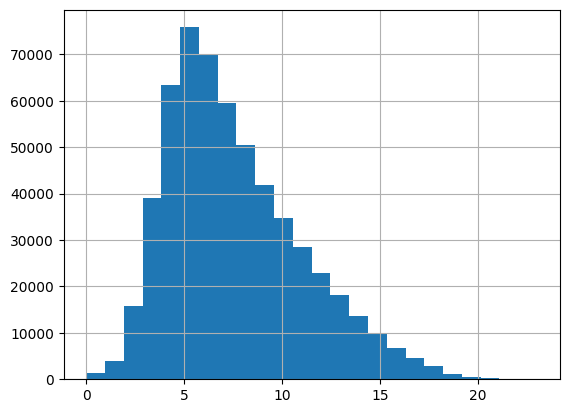

In [69]:
resample_SOFA.SOFA.hist(bins=24)

# Urine Output

In [64]:
def resample_uo(chartevents_,icustays,itemid):
    rt = []
    chartevents_['charttime'] = pd.to_datetime(chartevents_['charttime'])
    icustays_intime = icustays[['subject_id','hadm_id','stay_id','intime']]
    icustays_intime['intime'] = pd.to_datetime(icustays_intime['intime'])
    icustays_intime = icustays_intime.rename(columns={'intime':'charttime'})

    icustays_outtime = icustays[['subject_id','hadm_id','stay_id','outtime']]
    icustays_outtime['outtime'] = pd.to_datetime(icustays_outtime['outtime'])
    icustays_outtime = icustays_outtime.rename(columns={'outtime':'charttime'})
    for i in tqdm(icustays.stay_id.unique()):
        tmp = chartevents_[chartevents_['stay_id']==i]
        tmp_id = icustays[icustays['stay_id']==i][['subject_id','hadm_id','stay_id']].iloc[0].to_list()
        tmp_intime = icustays_intime[icustays_intime['stay_id']==i]
        tmp_outtime = icustays_outtime[icustays_outtime['stay_id']==i]

        tmp = pd.concat([tmp, tmp_intime, tmp_outtime])
        tmp = tmp[(tmp['charttime'].values >= tmp_intime.charttime.values)&(tmp['charttime'].values <= tmp_outtime.charttime.values)]
        tmp.index = pd.DatetimeIndex(tmp['charttime'])
        tmp = pd.DataFrame(tmp['value'].resample(rule='H', origin='start').sum())
        tmp.reset_index(drop=False,inplace=True)
        tmp[['subject_id','hadm_id','stay_id']] = tmp_id
        tmp['itemid'] = itemid
        rt.append(tmp)
    return pd.concat(rt)

In [109]:
if not os.path.isfile('./data/resample/resample_uo.parquet'):
    resample_uo = resample_uo(outputevents_uo,icustays,'uo')
    resample_uo.to_parquet('./data/resample/resample_uo.parquet')
else : resample_uo = pd.read_parquet('./data/resample/resample_uo.parquet')

In [116]:
admission_weight = pd.read_parquet('./data/admission_weight.parquet')

In [128]:
def AKI_UO_annotation(df,admission_weight):
    for i in tqdm(range(6,49,1)):
        rolling_avg=df.groupby('stay_id').rolling(window=str(i)+'H', on='charttime',min_periods=i)['value'].mean().reset_index(drop=True)
        df['roll_%iH' % i] = rolling_avg
    df = pd.merge(df,admission_weight,on=['subject_id','stay_id'],how='left')
    df['6-12H_min'] = df[df.columns[6:13]].min(axis=1)/df['valuenum']
    df['12H-_min'] = df[df.columns[12:49]].min(axis=1)/df['valuenum']
    df['24H-_min'] = df[df.columns[24:49]].min(axis=1)/df['valuenum']
    df['AKI_UO']=0
    df.loc[df['6-12H_min']<0.5, 'AKI_UO'] = 1
    df.loc[df['12H-_min']<0.5, 'AKI_UO'] = 2
    df.loc[df['12H-_min']==0, 'AKI_UO'] = 3
    df.loc[df['24H-_min']<0.3, 'AKI_UO'] = 3
    df = df[['subject_id','hadm_id','stay_id','charttime','AKI_UO']]
    return df

In [122]:
rolled_uo = AKI_UO_annotation(resample_uo,admission_weight)

  0%|          | 0/43 [00:00<?, ?it/s]

In [130]:
rolled_uo['AKI_UO'].value_counts()

AKI_UO
0    4299223
2    1075523
1     599387
3     125301
Name: count, dtype: int64

In [131]:
rolled_uo

,subject_id,hadm_id,stay_id,charttime,AKI_UO
0,10000032,29079034,39553978,2180-07-23 14:00:00,0
1,10000032,29079034,39553978,2180-07-23 15:00:00,0
2,10000032,29079034,39553978,2180-07-23 16:00:00,0
3,10000032,29079034,39553978,2180-07-23 17:00:00,0
4,10000032,29079034,39553978,2180-07-23 18:00:00,0
...,...,...,...,...,...
6099429,19999987,23865745,36195440,2145-11-04 16:59:00,0
6099430,19999987,23865745,36195440,2145-11-04 17:59:00,0
6099431,19999987,23865745,36195440,2145-11-04 18:59:00,0
6099432,19999987,23865745,36195440,2145-11-04 19:59:00,0
